In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Goal

To see how the sequential autoencoder approach (TODO describe) performs in finding factors that are relevant to asset-price anomalies, compared to the economics-informed PCA approach. Performance of each model is measured by how much of the variance is explained by the factors found. If the autoencoder model can match the performance of the economics-informed PCA one, that suggests that it can learn an equally informative set of economic knowledge from the trends in the data alone.

### Load and organize returns data

The data set (see citations) is set up as follows:
* One group of CSV files per anomaly, identified by filename prefix. We are only interested in the group prefixed `ret` for anomalous returns.
* In this group are 55 files, one per characteristic of an individual stock, such as price. Characteristic is indicated by filename suffix.
* Example file:

In [2]:
df = pd.read_csv('DataSet/monthly/ret10_price.csv', index_col='date')
df

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10
date,,,,,,,,,,
07/1963,-0.016110,-0.016420,-0.014429,-0.012837,-0.011873,-0.006876,-0.005049,0.000657,-0.000842,0.003301
08/1963,0.032904,0.027416,0.048415,0.048101,0.071222,0.060035,0.053034,0.064582,0.060898,0.048308
09/1963,-0.014653,-0.014772,-0.004352,-0.024909,-0.014166,-0.006128,-0.022373,-0.033295,-0.019617,-0.006241
10/1963,0.014183,0.015139,0.020362,-0.001361,0.012925,-0.009800,0.015713,0.001680,0.013357,0.049630
11/1963,-0.034110,-0.011294,0.016071,0.003260,0.002138,-0.007177,-0.007279,-0.014306,-0.010153,-0.003912
...,...,...,...,...,...,...,...,...,...,...
08/2019,-0.078559,-0.102274,-0.074431,-0.060736,-0.054562,-0.039603,-0.042928,-0.023711,-0.003197,-0.014348
09/2019,0.041238,0.034295,0.047052,0.030790,0.034646,0.025590,0.043141,0.031079,0.013854,-0.000509
10/2019,-0.022744,0.022176,0.015909,-0.007088,0.042427,0.020122,0.013390,0.009148,0.010597,0.033841


* For each characteristic, all the stocks under consideration are sorted into deciles by that characteristic. Each decile is treated as a portfolio labeled p1 through p10 and these are the columns of the corresponding file.
    * One complication is that some characteristics are categorical or otherwise don't have meaningful deciles. These files still have columns p1-p10 but some columns are disused and empty.
* Rows correspond to dates. There is one row per month in the range ~1963-2019.
    * A cell in a row may be unpopulated due to missing data for that month even when the column as a whole isn't empty.
    * Different files cover slightly different date ranges.
* Individual cells are the value-weighted returns for each portfolio during each month. For example, the bottom right cell above shows that in Dec. 2019, a portfolio of all stocks priced in the 10th decile had a return of 0.026909.

#### Start by merging all characteristics together into one data frame
Merge will take place horizontally so that the result will still have one row per month and one column per portfolio, but will include a set of decile-sorted portfolios for every characteristic.

In [3]:
import os
# Grab names of anomalous-return files
PATH = 'DataSet/monthly/'
FILE_PREFIX = 'ret10_'
FILE_EXTENSION = '.csv'
filenames = [filename for filename in os.listdir(PATH) if filename.startswith(FILE_PREFIX)]
print(f'Found {len(filenames)} files of anomalous-return data')
# Load files one by one into same dataframe
merged = pd.DataFrame(index=pd.DatetimeIndex([], name='date'))
non_decile, missing_data, complete = (set(), set(), set()) # keep track of data completeness while loading
for filename in filenames:
    characteristic_of = lambda fn: fn[len(FILE_PREFIX):-len(FILE_EXTENSION)]
    df = pd.read_csv(PATH + filename, index_col='date', parse_dates=True, date_format='%m/%Y')
    ### Preliminary cleaning step: skip nondecile characteristics / other missing data
    def is_missing_data(df):
        # Non-decile characteristics have columns populated entirely with NaN
        for col in df.columns:
            if df[col].count() == 0:
                non_decile.add(characteristic_of(filename))
                return True
        # Scan for missing cells in populated columns as well
        for col in df.columns:
            if df[col].hasnans:
                missing_data.add(characteristic_of(filename))
                return True
        complete.add(characteristic_of(filename))
        return False
    if is_missing_data(df):
        continue
    ### End preliminary cleaning step
    df.rename(columns=lambda c: f'{characteristic_of(filename)}_{c}', inplace=True) # prefix columns with characteristic
    merged = merged.merge(df, 'outer', 'date')
    # Outer join to keep months that are missing whole characteristics for now
    # These will be handled in a later cleaning step
print('Summary:')
print(f'\t{len(non_decile)} non-decile characteristics: {non_decile}')
print(f'\t{len(missing_data)} characteristics with missing cells: {missing_data}')
print(f'\t{len(complete)} characteristics with complete data: {complete}')
print('Using only characteristics with complete data')
merged

Found 55 files of anomalous-return data
Summary:
	5 non-decile characteristics: {'debtiss', 'exchsw', 'fscore', 'ipo', 'repurch'}
	9 characteristics with missing cells: {'roa', 'nissa', 'gltnoa', 'rome', 'nissm', 'invaci', 'age', 'sue', 'roe'}
	41 characteristics with complete data: {'strev', 'divp', 'roaa', 'noa', 'accruals', 'roea', 'value', 'lev', 'sgrowth', 'valmom', 'invcap', 'divg', 'season', 'prof', 'aturnover', 'gmargins', 'price', 'cfp', 'sp', 'momrev', 'ep', 'shortint', 'indmomrev', 'mom12', 'dur', 'mom', 'indrrevlv', 'indmom', 'ciss', 'lrrev', 'valprof', 'size', 'igrowth', 'inv', 'valuem', 'growth', 'ivol', 'shvol', 'valmomprof', 'indrrev', 'betaarb'}
Using only characteristics with complete data


,accruals_p1,accruals_p2,accruals_p3,accruals_p4,accruals_p5,accruals_p6,accruals_p7,accruals_p8,accruals_p9,accruals_p10,...,sp_p1,sp_p2,sp_p3,sp_p4,sp_p5,sp_p6,sp_p7,sp_p8,sp_p9,sp_p10
date,,,,,,,,,,,,,,,,,,,,,
1963-07-01,-0.012826,-0.035516,-0.001749,-0.002739,0.012370,0.004111,0.003346,-0.005244,-0.005873,0.007966,...,0.001246,0.016596,0.003354,0.004370,-0.002039,-0.021691,-0.013344,-0.018734,-0.020539,-0.006043
1963-08-01,0.067188,0.075105,0.065833,0.059440,0.050219,0.043807,0.052063,0.097553,0.046265,0.069205,...,0.045485,0.041143,0.048661,0.059708,0.069453,0.071549,0.057740,0.047063,0.083413,0.043130
1963-09-01,0.027254,-0.036061,-0.025227,-0.021122,-0.031047,-0.020266,0.006704,-0.001180,0.000810,-0.001218,...,-0.002031,-0.029466,-0.023707,-0.004787,-0.016817,-0.015236,-0.005143,-0.021049,-0.009069,-0.033984
1963-10-01,0.000835,0.018604,0.051991,0.028729,0.022873,-0.002550,0.033786,0.020920,0.068880,0.138922,...,0.033032,-0.009433,0.030700,0.060448,0.021997,0.033764,0.015734,0.017601,0.038851,0.009602
1963-11-01,-0.007417,0.006792,-0.006046,-0.013141,0.000565,-0.012780,0.020039,-0.004045,-0.008319,-0.065160,...,0.018028,-0.012895,-0.011324,-0.029286,-0.011138,-0.007688,-0.000038,0.011123,-0.004890,-0.003218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,-0.011983,-0.026596,-0.033196,-0.019816,-0.017636,-0.034318,0.004716,-0.013897,-0.017711,-0.003340,...,-0.007943,-0.030568,-0.024177,-0.003217,-0.014945,-0.048403,-0.068869,-0.035887,-0.049141,-0.063963
2019-09-01,0.011086,0.027976,0.009426,0.025268,0.021759,0.024613,0.017311,0.012674,-0.000337,-0.010182,...,-0.019202,0.022650,0.037942,0.031047,0.036637,0.016883,0.035709,0.039095,0.055311,0.060977
2019-10-01,0.041932,0.034752,0.040694,-0.004829,0.014374,0.004451,0.002337,0.044002,0.005615,0.017040,...,0.028577,0.031458,0.015161,0.005760,0.009017,0.015486,0.014394,0.019023,0.044380,0.010251


#### Cross-reference with PCA paper

Since we're comparing the performance of the sequential autoencoder to the performance of economics-informed PCA from Bryzgalova et al, it's worth seeing how our set of characteristics compares to the 37 used in that paper. (Eliminating characteristics with incomplete data gets us close but not all the way to 37.)

In [4]:
# Check existence & completeness of the 37 in our data set
firm_specific_characteristics = {
    'reversal': {'lrrev', 'strev', 'indmomrev', 'indrrev', 'indrrevlv'},
    'value interaction': {'valmom', 'valmomprof', 'valprof'},
    'investment': {'inv', 'invcap', 'igrowth', 'growth', 'noa'},
    'momentum': {'mom', 'mom12', 'indmom', 'momrev'},
    'value': {'value', 'valuem', 'divp', 'ep', 'cfp', 'sp'},
    'other': {'size', 'price', 'accruals', 'ciss', 'gmargins', 'lev', 'season', 'sgrowth'},
    'trading frictions': {'ivol', 'shvol', 'aturnover'},
    'profitability': {'prof', 'roaa', 'roea'}
}

characteristic_set = set()
for chars in firm_specific_characteristics.values():
    characteristic_set = characteristic_set.union(chars)
if len(characteristic_set) != 37:
    raise ValueError(len(characteristic_set)) # sanity check
# for characteristic in characteristic_set:
#     if characteristic in non_decile:
#         print(f'{characteristic}: non_decile')
#     elif characteristic in missing_data:
#         print(f'{characteristic}: missing')
#     elif characteristic in complete:
#         print(f'{characteristic}: complete')
#     else:
#         print(f'{characteristic}: ???')
print(f'Characteristics that are in the 37 but NOT complete: {characteristic_set.difference(complete)}')
print(f'Characteristics that are complete but NOT in the 37: {complete.difference(characteristic_set)}')

Characteristics that are in the 37 but NOT complete: set()
Characteristics that are complete but NOT in the 37: {'betaarb', 'dur', 'divg', 'shortint'}


Our data set is complete with respect to these 37 characteristics, and has four additional characteristics that may or may not be useful. These can be ignored for the purposes of cross-referencing.

In [5]:
# Cross-reference summary statistics
# TODO Sharpe ratio?
categories = []
top_decile_means = []
bottom_decile_means = []
for category, characteristics in firm_specific_characteristics.items():
    top_decile_sum = 0
    bottom_decile_sum = 0
    count = 0
    for characteristic in characteristics:
        top_decile_sum += merged[characteristic + '_p10'].iloc[4:-24].sum()
        bottom_decile_sum += merged[characteristic + '_p1'].iloc[4:-24].sum()
        count += merged[characteristic + '_p1'].iloc[4:-24].count() # same for all columns but this is an easy way to get at it
    categories.append(category)
    top_decile_means.append(top_decile_sum / count)
    bottom_decile_means.append(bottom_decile_sum / count)
summary_stats = pd.DataFrame()
summary_stats['Category'] = categories
summary_stats['Bottom-Decile Mean'] = bottom_decile_means
summary_stats['Top-Decile Mean'] = top_decile_means
summary_stats.style.format({'Bottom-Decile Mean': '{:.2%}'.format, 'Top-Decile Mean': '{:.2%}'.format})

,Category,Bottom-Decile Mean,Top-Decile Mean
0,reversal,0.58%,1.41%
1,value interaction,0.72%,1.42%
2,investment,0.79%,1.10%
3,momentum,0.69%,1.32%
4,value,0.82%,1.24%
5,other,0.81%,1.07%
6,trading frictions,0.64%,0.96%
7,profitability,0.81%,1.03%


#### Clean data

TODO check for malformed data, data-entry errors resulting in outliers, etc?

In [6]:
cleaned = merged.loc[:,[col[:col.index('_')] in characteristic_set for col in merged.columns]]

Another kind of missing data: since characteristics don't all cover the same date range, some months are missing whole characteristics. These show up as NaNs - see if restricting to the same date range in the paper will clean them up:

In [7]:
cleaned = cleaned.iloc[4:-24]
for column in cleaned:
    if cleaned[column].hasnans:
        raise ValueError(column)

### PCA

Taking the merged data frame and restricting it to only features from the paper would give us 370 columns. However, it appears the original paper may be doing PCA on 10 subsets of those 370 columns broken out by decile: all p1 columns, all p2 columns, etc. 

Use a rough visual approximation of the broken-stick method to find the optimal number of components:

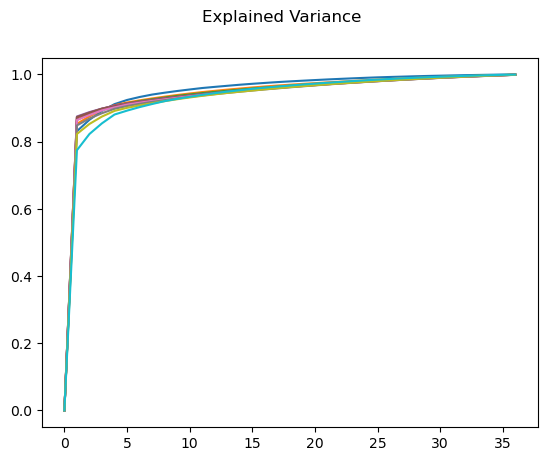

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def pca_plot(df):
    scaled = StandardScaler().fit_transform(df)
    explained_variances = np.zeros(len(df.columns))
    for i in range(0, len(explained_variances)):
        pca = PCA(i)
        pca.fit(scaled)
        explained_variances[i] = sum(pca.explained_variance_ratio_)
    plt.plot(explained_variances)
plt.suptitle("Explained Variance")
for i in range(1, 11):
    subframe = cleaned.loc[:,[str(i) == col[col.index('_')+2:] for col in cleaned.columns]]
    pca_plot(subframe)

These 10 subsets agree on an ideal number of components around 4, but it's also worth comparing the analogous plot for the entire data set.

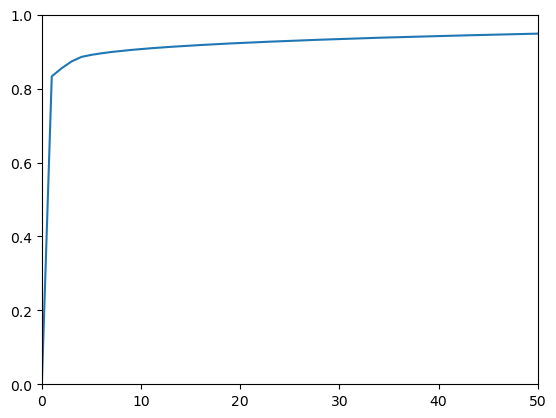

In [20]:
plt.axis((0, 50, 0, 1)) # x max of 50 found by first plotting w/o axis constraints
pca_plot(cleaned)

--------

## Thoughts & questions

- Is this the right data set from the paper? That one says 37 characteristics, this data set has 55
  - Also their sample period is shorter (11/1963 to 12/2017 - we have 07/1963 to 12/2019)
  - Take the 37 & throw out the rest? (See if cleaning up the non-decile ones does that anyway) -> nope, reduces to 50
  - What about also removing the ones with empty cells? -> nope, 41
    - Reasons why the remaining 4 complete ones aren't relevant isn't apparent from their descriptions
  - Summary stats = Table B.1? Top & bottom decile means + Sharpe ratio (top - bottom)?
    
- Confirm that data format is:
  - Rows: months from the time series
  - Columns: all combinations of (characteristic, decile)
  - Effect is like concatting the 55 tables sideways to make 550 columns (and naming each tablename+columnname for uniqueness)
  - Not inherently sparse - each combination of characteristic & decile does have a cell in the original data
  e.g.

  | Date       | 1st-decile price | 2nd-decile price | ... | 1st-decile market cap | 2nd-decile market cap | ... |
  | ---        | ---              | ---              | --- | ---                   | ---                   | --- |
  | Sept. 1971 | return cell 1A   | return cell 1B   | ... | etc.                  | etc.                  | ... |
  | Oct. 1971  | return cell 2A   | return cell 2B   | ... | etc.                  | etc.                  | ... |
  | ...        | ...              | ...              | ... | ...                   | ...                   | ... |
  
  
- How do the factors apply to an individual stock which occupies only one decile for each characteristic?
  - For prediction, presumably its return from period t would go into the autoencoder as a sparse vector populated by characteristics, i.e. if its price is in the 6th decile then its return goes into the 6th-decile price input and all other price inputs get 0 - repeat for its other characteristics.
  - This answers the question of why it's not a problem that stocks move between deciles as time goes by. If we're using returns at t to predict returns at t+1 then we only care about the stock's characteristics at t
  - OK but how do the factors correspond to a linear combination of stocks? Is "a stock" not bound to a company i.e. GOOG or CSX but rather to a set of parameters like (price_decile=A, marketcap_decile=B, etc.) such that any company can assume the role of that stock when its shares match those parameters?
    
- Deciles are ordinal data and here we are treating them like categorical. Isn't that throwing out perfectly good data? I assume (and Bryzgalova et al back me up with what they say about monotonicity) that if we know how it affects returns to have a price in the first decile, then the effect of a price in the second decile should be closely related. Will the factors just pick that up on their own? (Or maybe we do something convolution-like between input & compression layer?)

- Data cleaning TODO above

- What if broken-stick method gives a different optimal number of factors for different deciles' subsets of the data?

- Use straight PCA results to estimate how much extra variance the economic information in the paper's model can explain?

- The exploration/cleaning of the data set is kind of a mess: it goes back and forth between trying to find the biggest clean data set possible from first principles and trying to use the exact subset of rows/columns from the paper (verifying that this subset is also clean). How much of the mess needs to be kept as a show of reasoning process and how much can be refactored? (Git history = process?)

--------

#### Citations

1. Idea and ongoing guidance provided by Cameron Fen
1. Brygalova, DeMiguel, Li, Pelger (2023) "Asset-Pricing Factors with Economic Targets"
1. Haddad, Kozak, Santosh (2020) "Factor Timing"
1. Giglio, Kelly, Kozak (2020) "Equity Term Structures without Dividend Strips Data"
1. [Data set provided by Serhiy Kozak](https://drive.google.com/file/d/1ocP9FPtZQtfYetqvsPkUwwqvbAcyU1qe/view?usp=sharing)